Streaming Basemap Data
=====================

The primary goal of the Planet Basemaps product is to enable easy streaming of analysis ready data directly into a desktop GIS application, web application, or your analysis script without needing to explicitly activate, download, or transfer data.  This allows rapid analysis and visualization at a variety of different spatial scales.

Let's explore a few different mechanisms of streaming basemap data and explain why this is often easier and more useful than explicitly downloading data.  We'll also explore a few common workflows using these mechanisms to preform large area analysis and timeseries analysis.

To start with, if you haven't already, review `basemaps_api_introduction.ipynb` located alongside this notebook. We'll be using the examples and demo client described in detail there.

Note that these examples assume you have `PL_API_KEY` set in your environment.

WMTS Access
--------------------

WMTS (Web Map Tile Service) is a common streaming protocol that is closely related to the WMS (Web Map Service) protocol.  This protocol is widely supported by many GIS applications and is an excellent way to quickly access mosaics in GIS systems, but it has some limitations compared to lower-level methods.  WMTS is best used when you're only wanting to use data as a visual backdrop or visually inspect changes.  However, you can use it programatically, and it's often a handy choice for quickly making visualizations from CLI tools or scripts.  

If you don't have the gdal command line tools installed or are on Windows, feel free to skip this first example. The later examples do not depend on it.

For example, let's extract an NDVI visualization over Brazil from a NICFI mosaic for July 2024 using standard `gdal` command line tools. 

In [1]:
! rm -f brazil_ndvi.png && gdalwarp \
    -crop_to_cutline \
    -cutline brazil.geojson \
    -of PNG \
    -tr 2500 2500 \
    "WMTS:https://api.planet.com/basemaps/v1/mosaics/wmts?proc=ndvi&color=viridis&api_key=$PL_API_KEY,layer=planet_medres_normalized_analytic_2024-07_mosaic" \
    brazil_ndvi.png

Using band 4 of source image as alpha.
Creating output file that is 2010P x 1833L.
0...10...20...30...40...50...60...70...80...90...100 - done.


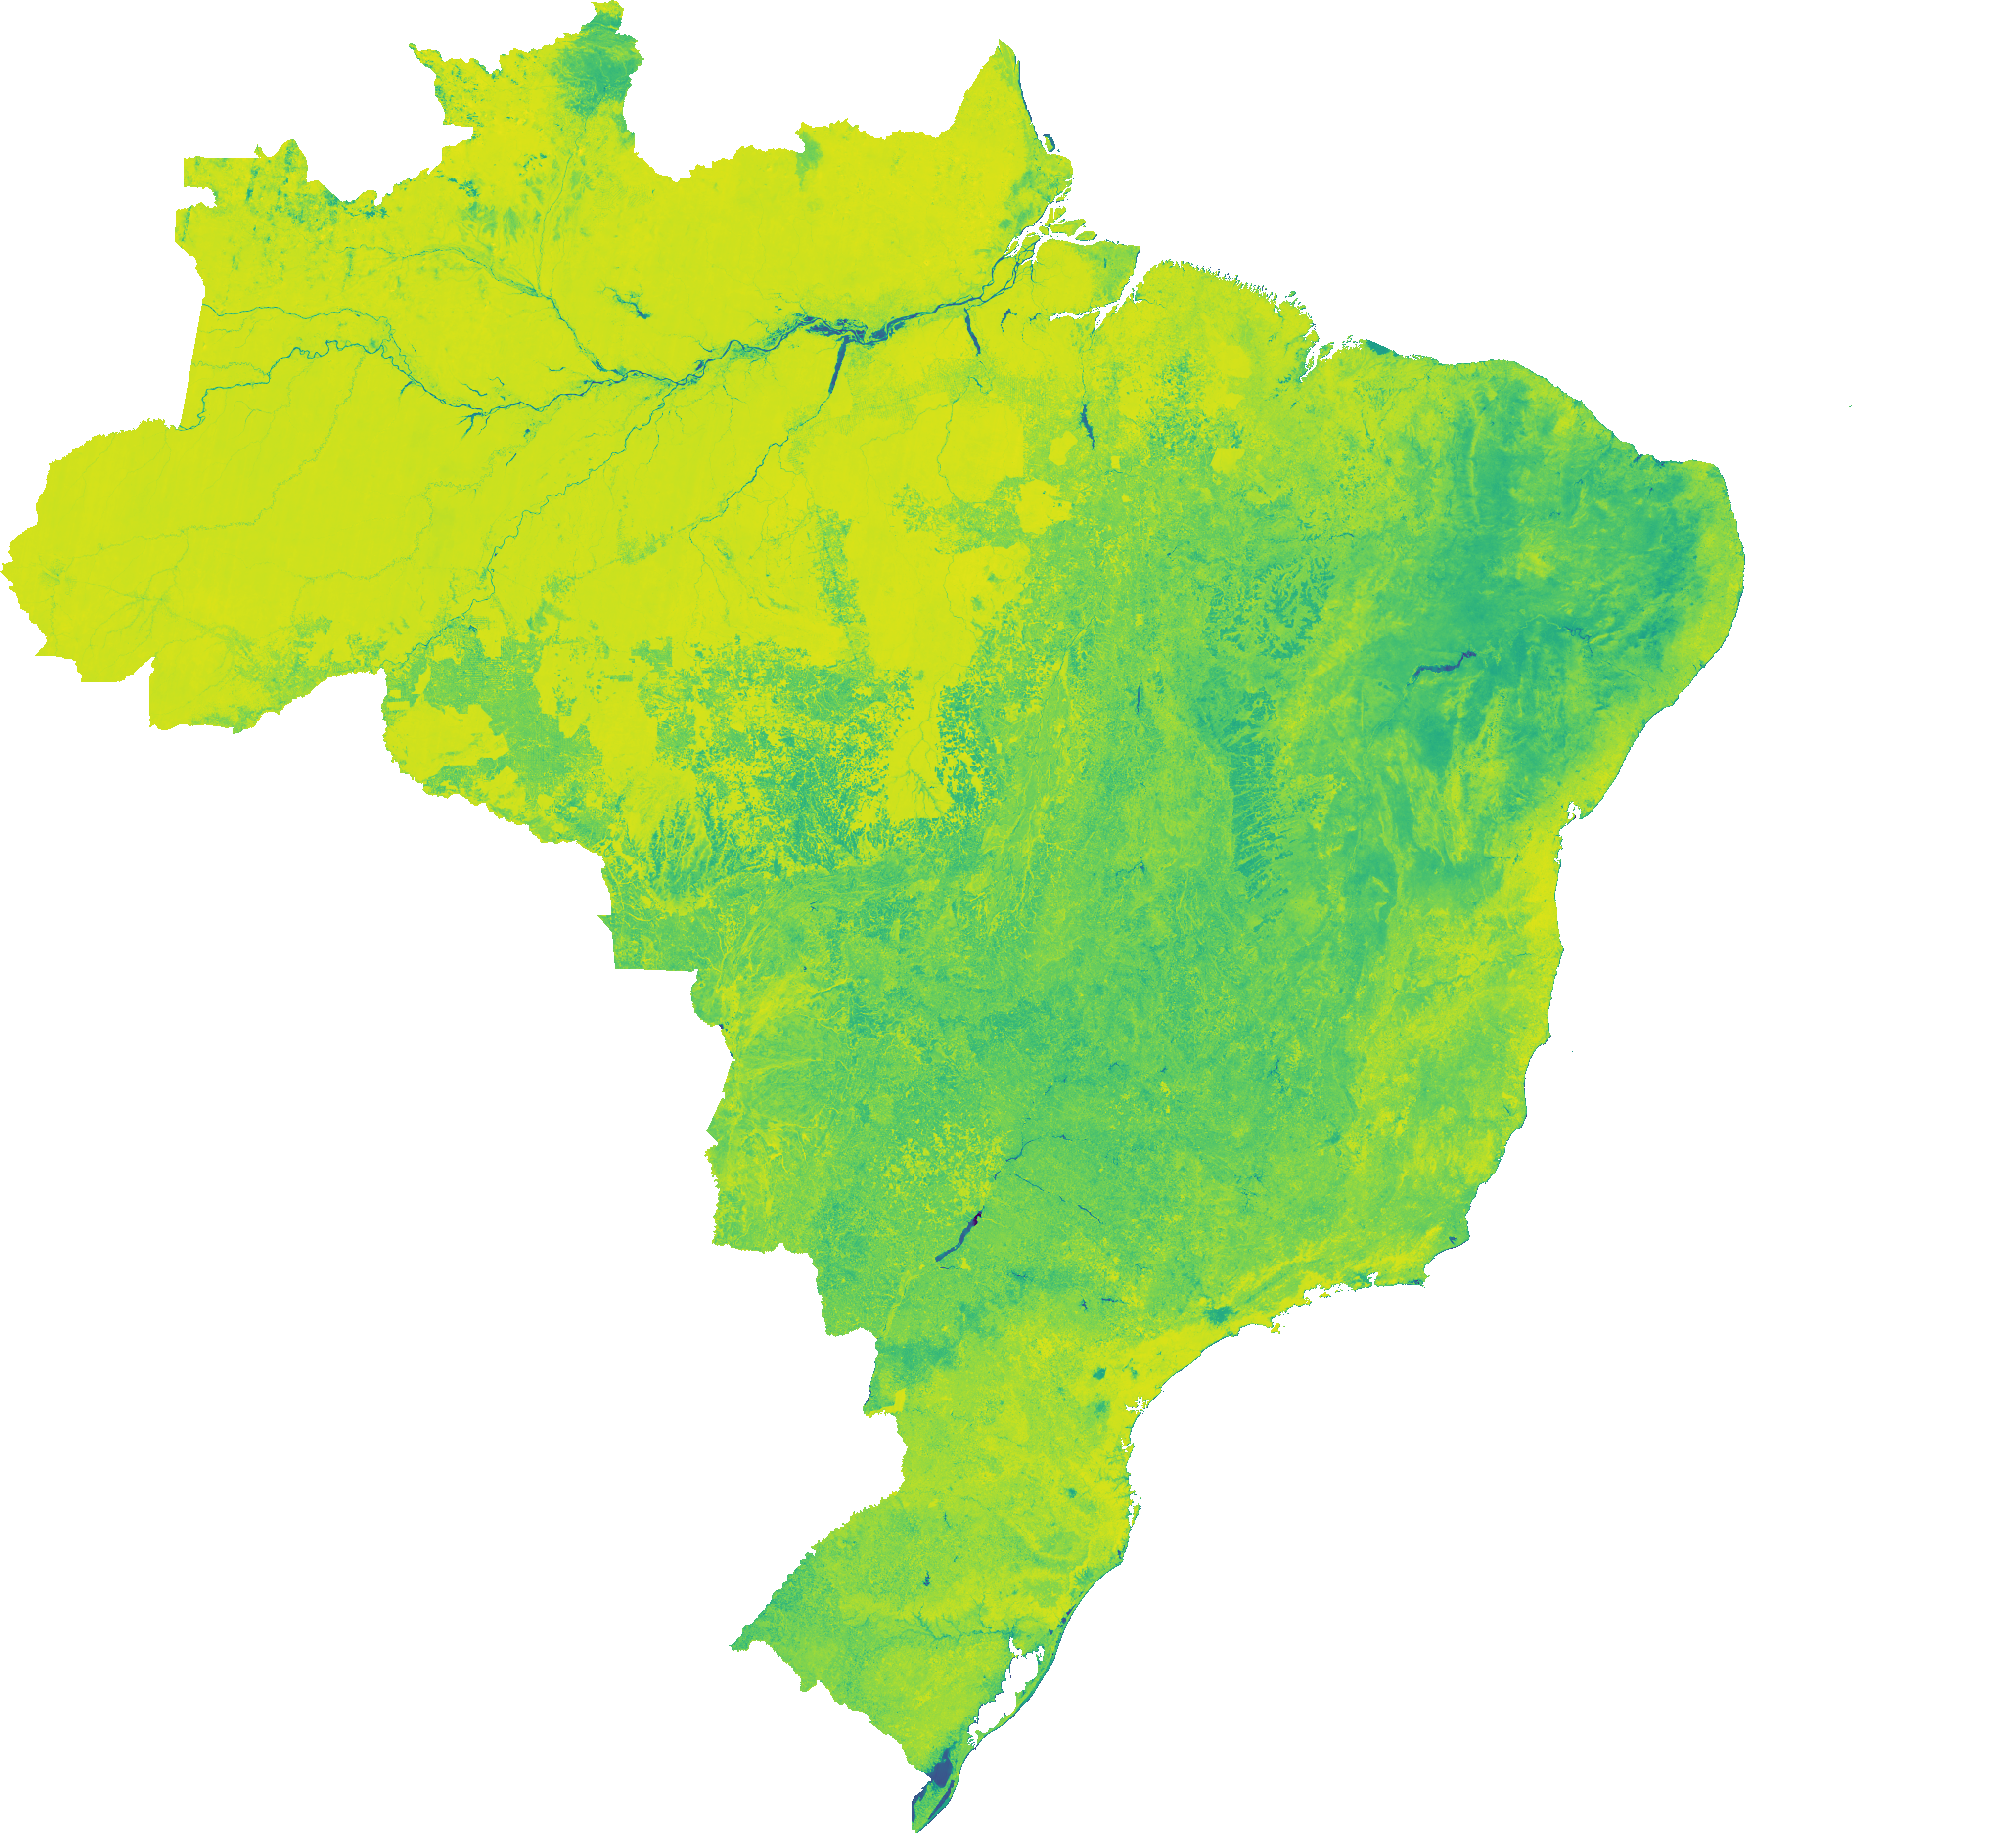

In [2]:
from IPython.display import Image
Image('brazil_ndvi.png')

We can do the same thing in `rasterio` using standard techniques for extracting data over a specific geometry. Just for the sake of variety, we'll extract a false color infrared view instead of NDVI and we'll also work with a specific zoom (i.e. overview) level instead of defining a cellsize manually. Note that these are the same approaches you'd use in rasterio for a local geotiff file or any other raster data source, and we'll reuse them later on in this example:

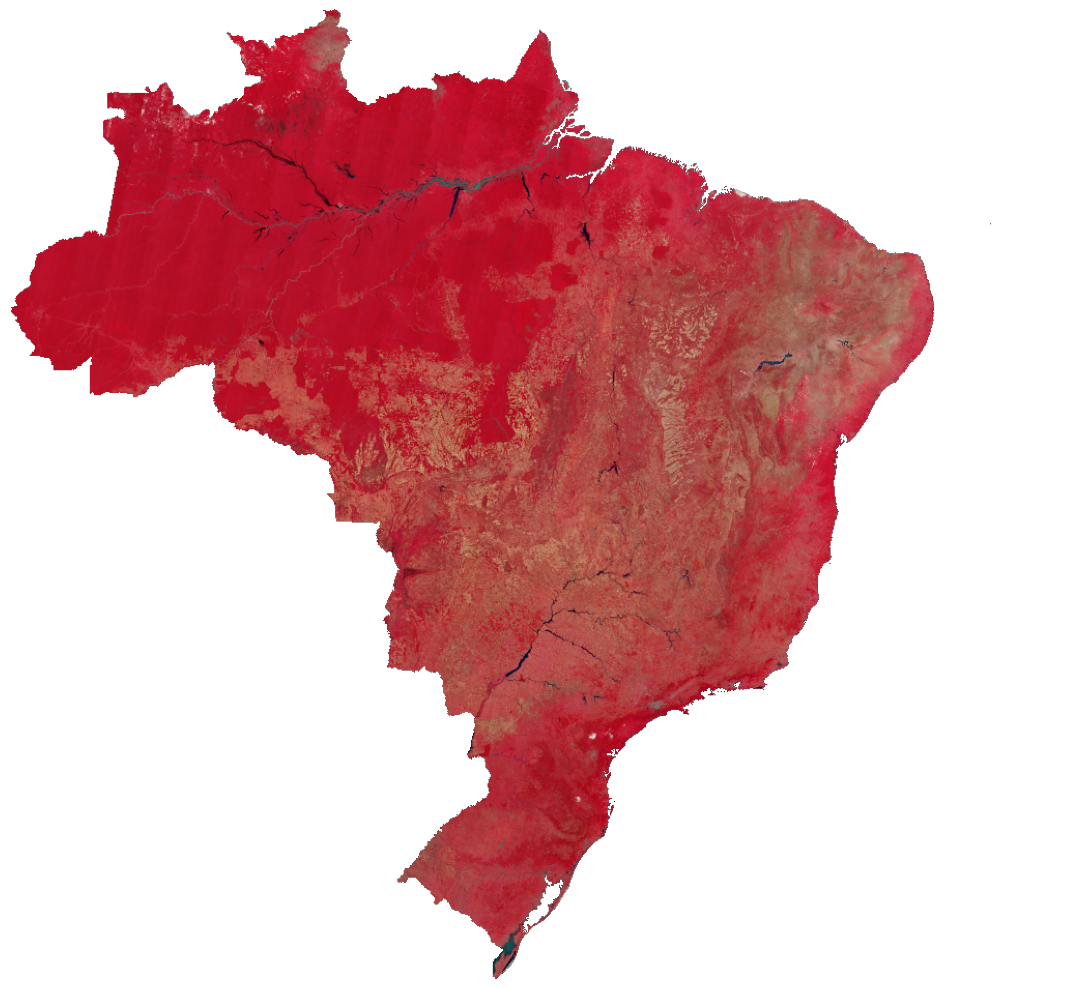

In [3]:
import os
import json

import numpy as np
import rasterio as rio
from rasterio.mask import mask
from rasterio.warp import transform_geom
import matplotlib.pyplot as plt


def read_polygon(path, aoi):
    """
    Extract data from a gdal-readable *path* inside the geojson *aoi*.
    
    :param str path:
        A local path to a gdal-readable file or an equivalent specifier
    :param dict aoi:
        A single geojson polygon or multipolgyon (not a feature collection)
    """
    with rio.open(path) as src:
        # Reproject the polygon into the raster's projection
        poly = [transform_geom({'init': 'EPSG:4326'}, src.crs, aoi)]
        # We don't need "transform" here unless we want to save the data
        data, transform = mask(src, poly, crop=True)
    return data


api_key = os.environ['PL_API_KEY']
wmts_url = "https://api.planet.com/basemaps/v1/mosaics/wmts"
mosaic = "planet_medres_normalized_analytic_2024-07_mosaic"
level = 5
wmts_spec = f"WMTS:{wmts_url}?proc=cir&api_key={api_key},layer={mosaic},zoom_level={level}"

with open('brazil.geojson', 'r') as f:
    brazil_aoi = json.load(f)
    
data = read_polygon(wmts_spec, brazil_aoi)

# And now we'll display the result:
fig, ax = plt.subplots(figsize=(12, 10))
ax.imshow(np.moveaxis(data, 0, -1))
ax.axis('off')
fig.tight_layout()
plt.show()

However, there is a _very_ major downside to these approaches. We're not getting the actual data. Instead, we're streaming an RGB visualization of the data.  That's fine for visual mosaics or use cases where we only need a visualization, but it's not an option for most analysis.  Next, we'll look at ways to stream the underlying data for analysis, rather than streaming a pre-rendered visualization.

Streaming Individual Quads
----------------------------------------

One way of accessing data without download is to work with URLs to a geotiff file for a single quad.  You don't need to download the quad to use the data, and you can leverage the fact that mosaic data is in Cloud-Optimized Geotiff (COG) format to efficiently extract only the data you need.  

As an example, let's work with a timeseries of the average values over a mining area in the Puverian Amazon that happens to overlap only one quad.  For each mosaic (i.e. timestep) in the series, we'll use the `vsicurl` gdal driver to access data from the URL without downloading the full quad. To speed things up, we'll make parallel requests to the Basemaps API, however, this will still take some time to run. (We'll cover a faster approach soon.) This example will use the demo `basemaps_client` covered in the `basemaps_api_introduction.ipynb` notebook alongside this notebook.

/home/joe/anaconda3/envs/basemaps_internal/lib/python3.9/site-packages/rasterio/features.py:366: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _rasterize(valid_shapes, out, transform, all_touched, merge_alg)


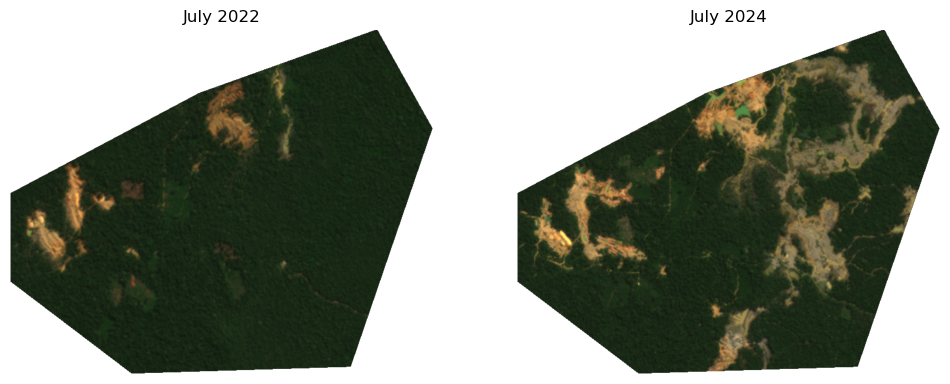

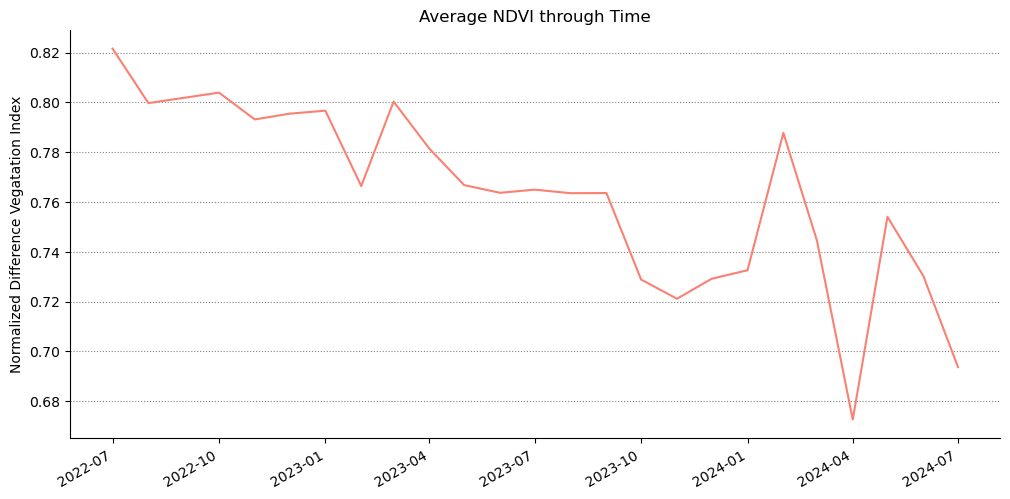

In [4]:
from concurrent.futures import ThreadPoolExecutor

import basemaps_client


def extract_data(aoi, mosaic):
    quad, = mosaic.quads(region=aoi)
    path_spec = f"/vsicurl/{quad.download_url}"
    return read_polygon(path_spec, aoi)
    

def average_values(aoi, mosaic):
    data = extract_data(aoi, mosaic)
    # Separate alpha band from the data bands
    data, alpha = data[:-1], data[-1]
    # Exclude nodata values based on alpha band. 0 _is_ a valid data value
    # Only 0 in the alpha band indicates invalid pixels.
    return [band[alpha != 0].mean() for band in data]


def rgb(data, display_max=2500):
    """Make a crude RGB display in Matplotlib's convention"""
    alpha = (data[-1] != 0).astype(float)
    data = np.clip(data[[2, 1, 0]], 0, display_max)
    data = np.moveaxis(data, 0, -1).astype(float) / display_max
    return np.dstack([data, alpha])

mining_aoi = { 
    "type": "Polygon", 
    "coordinates": [[[-70.0440, -12.6842], [-70.0440, -12.6907], 
                     [-70.0348, -12.6975], [-70.0182, -12.6970], 
                     [-70.0120, -12.6794], [-70.0162, -12.6721], 
                     [-70.0297, -12.6768], [-70.0440, -12.6842]]]}

series = basemaps_client.MosaicSeries.from_name('PS Tropical Normalized Analytic Monthly Monitoring')
mosaics = list(series.mosaics(start_date='2022-07-01', end_date='2024-08-01'))

func = lambda mosaic: average_values(mining_aoi, mosaic)
with ThreadPoolExecutor(max_workers=32) as executor:
    values = list(executor.map(func, mosaics))

blue, green, red, nir = np.array(values).T
ndvi = (nir - red).astype(float) / (nir + red)
time = [x.start_date for x in mosaics]

t1 = extract_data(mining_aoi, mosaics[0])
t2 = extract_data(mining_aoi, mosaics[-1])

fig, axes = plt.subplots(figsize=(12, 6), ncols=2)
axes[0].imshow(rgb(t1))
axes[0].set(title=mosaics[0].start_date.strftime('%B %Y'))
axes[1].imshow(rgb(t2))
axes[1].set(title=mosaics[-1].start_date.strftime('%B %Y'))
for ax in axes.flat:
    ax.axis('off')

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(time, ndvi, color='salmon', label='NDVI')
ax.set(title='Average NDVI through Time', ylabel='Normalized Difference Vegatation Index')
ax.grid(axis='y', ls=':', color='gray')
ax.spines['top'].set(visible=False)
ax.spines['right'].set(visible=False)
fig.autofmt_xdate()

plt.show()

This approach is entirely reasonable for analysis of small AOIs that only intersect a single quad. However, it falls apart as soon as you need to do a larger analysis or your AOI happens to intersect multiple quads.  While it's possible to handle small AOIs that intersect multiple quads by making a virtual raster file (VRT) on the fly, you'll still quickly find analysis of even modest-sized AOIs to impractical with this approach.

Therefore, we need to look at other ways of streaming larger areas.

Full Bit Depth Streaming
-----------------------------------

Streaming via XYZ or WMTS or similar protcols typically uses 8-bit (i.e. 0-255 valued) image formats like PNG, WEBP, or JPEG.  However, the protocols themselves aren't limited to only 8-bit.  While not all clients support it, it is possilbe to use 16-bit tif tiles with many of these protocols.  GDAL is one of the most widely used I/O libraries for geospatial data, so it winds up being one of the most common clients for streaming protocols in practice.  GDAL supports 16-bit tif tiles in an XYZ streaming protocol, and that means that you can use this approach with any tooling that's based on GDAL.  That means that `rasterio`, `QGIS`, `ArcPro` and many other common GIS toolsets natively support full bit depth streaming.

So what does that mean?  It means we can tell gdal to stream the _entire_ mosaic in 16-bit, just like we did with WMTS, but getting 0-10000 surface reflectance or floating point NDVI values.  While this notebook focuses primarily on using full bit depth streaming programatically in Python, the XML description file is also extremely useful in desktop GIS systems, where it allows you to work with the raw data interactively as needed.

Note that using bull bit depth streaming consumes tile view quota just like viewing the data would. If you preform large amounts of analysis at a high resolution, you may exhaust your tile view quota. However, using coarser resolution (i.e. a lower zoom level) will consume fewer tiles and can allow analysis of very large areas with minimal tile view consumption.

Let's start with the example near the bottom of the XYZ tile services documentation page: https://developers.planet.com/docs/basemaps/tile-services/xyz/

That example gives the following XML as an example of configuring GDAL-based tools to stream a single timestep of the NICFI monthly series (`planet_medres_normalized_analytic_2024-07_mosaic` is the timestep):

```
<GDAL_WMS>
        <Service name="TMS">
        <ServerUrl>https://tiles.planet.com/basemaps/v1/planet-tiles/planet_medres_normalized_analytic_2024-07_mosaic/gmap/${z}/${x}/${y}.tif?api_key={api-key}&amp;empty=404&amp;format=geotiff&amp;proc=off</ServerUrl>
        </Service>
        <DataWindow>
            <UpperLeftX>-20037508.34</UpperLeftX>
            <UpperLeftY>20037508.34</UpperLeftY>
            <LowerRightX>20037508.34</LowerRightX>
            <LowerRightY>-20037508.34</LowerRightY>
            <TileLevel>15</TileLevel>
            <TileCountX>1</TileCountX>
            <TileCountY>1</TileCountY>
            <YOrigin>top</YOrigin>
        </DataWindow>
        <Projection>EPSG:3857</Projection>
        <BlockSizeX>256</BlockSizeX>
        <BlockSizeY>256</BlockSizeY>
        <BandsCount>5</BandsCount>
        <ZeroBlockHttpCodes>404,503</ZeroBlockHttpCodes>
        <ZeroBlockOnServerException>true</ZeroBlockOnServerException>
        <DataValues NoData="0 0 0 0 0" min="0 0 0 0 0" max="10000 10000 10000 10000 65535" />
        <DataType>uint16</DataType>
        <Cache/>
</GDAL_WMS>
```

Note that the example won't work as-is. As the docs mention, we need to either replace `{api-key}` in the XML template with our API key or alternatively configure some GDAL environment variables so that our credentials are passed along automatically.

Let's make a quick function to format that XML string for any 4-band + alpha SR mosaic and add in our API key:

In [5]:
def tileserver_xml(mosaic, api_key=None, level=15):
    if api_key is None:
        api_key = os.environ['PL_API_KEY']
    template = """<GDAL_WMS>
        <Service name="TMS">
        <ServerUrl>https://tiles.planet.com/basemaps/v1/planet-tiles/{mosaic}/gmap/${{z}}/${{x}}/${{y}}.tif?api_key={api_key}&amp;empty=404&amp;format=geotiff&amp;proc=off</ServerUrl>
        </Service>
        <DataWindow>
            <UpperLeftX>-20037508.34</UpperLeftX>
            <UpperLeftY>20037508.34</UpperLeftY>
            <LowerRightX>20037508.34</LowerRightX>
            <LowerRightY>-20037508.34</LowerRightY>
            <TileLevel>{level}</TileLevel>
            <TileCountX>1</TileCountX>
            <TileCountY>1</TileCountY>
            <YOrigin>top</YOrigin>
        </DataWindow>
        <Projection>EPSG:3857</Projection>
        <BlockSizeX>256</BlockSizeX>
        <BlockSizeY>256</BlockSizeY>
        <BandsCount>5</BandsCount>
        <ZeroBlockHttpCodes>404,503</ZeroBlockHttpCodes>
        <ZeroBlockOnServerException>true</ZeroBlockOnServerException>
        <DataValues NoData="0 0 0 0 0" min="0 0 0 0 0" max="10000 10000 10000 10000 65535" />
        <DataType>uint16</DataType>
        <Cache/>
    </GDAL_WMS>"""
    return template.format(mosaic=mosaic, api_key=api_key, level=level)

We can then use that just like we did the WMTS specification string earlier and pass it directly into rasterio. Let's inspect data for the mining AOI we looked at previously:

In [6]:
mosaic = 'planet_medres_normalized_analytic_2024-07_mosaic'
data = read_polygon(tileserver_xml(mosaic), mining_aoi)

# Just to demonstrate that this is _exactly_ the same data we got from the quads:
assert (data == t2).all()

# Let's print just a small section in the middle so we don't look at all nodata
print(data[:, 400:500, 400:500])

[[[  242   247   250 ...   526   485   453]
  [  245   244   254 ...   560   533   496]
  [  238   238   240 ...   569   573   525]
  ...
  [  586   642   679 ...   240   239   223]
  [  682   729   744 ...   227   230   227]
  [  743   767   773 ...   208   211   218]]

 [[  499   496   481 ...   875   807   735]
  [  503   485   460 ...   897   899   869]
  [  477   451   449 ...   907   964   966]
  ...
  [  875  1090  1233 ...   444   433   418]
  [ 1081  1266  1332 ...   398   420   422]
  [ 1253  1349  1371 ...   373   424   443]]

 [[  292   300   307 ...   959   893   792]
  [  288   289   295 ...  1005  1014   963]
  [  278   280   288 ...  1010  1073  1087]
  ...
  [  990  1194  1358 ...   291   280   263]
  [ 1232  1393  1497 ...   265   272   279]
  [ 1411  1520  1544 ...   238   262   287]]

 [[ 4373  4205  4059 ...  1968  1679  1580]
  [ 4290  3993  3827 ...  2140  1893  1637]
  [ 4081  3780  3552 ...  2336  2208  1966]
  ...
  [ 1614  1671  1741 ...  3019  3032  3045]
  

Note that we're getting all 5 bands (blue, green, red, NIR, and alpha) and that we're also getting uint16 values instead of 0-255 uint8 values.  This is the exact same values and data we get by working with the individual quads, but we don't need to worry about where the quads stop and end and we can treat the entire globe as one seamless file. It's also significantly faster, as we don't need to query for which quads overlap the AOI.

Another key point of this is that we can easily work with multiple scales of data. For an individual quad, we can only have overview levels that cover the same area the quad covers.  That makes it impractical to preform coarse-scale analysis over larger areas.  A key advantage of streaming is that we have access to all overview levels and can therefore very efficiently and easily extract data at 100 meter or 1 km or similar cellsizes.

In general, you'd use the same XML string, but tell GDAL to sample it at a specific pixel size.  This is what we did in the very first example using `gdalwarp`.  In `rasterio`, you'd do that by using a windowed read. Unfortunately, that's a touch more involved in `rasterio` when also extracting data for a specific AOI.  It's still very possible, but in this case, we have an easier option.  We can specify a specific [zoom level](https://wiki.openstreetmap.org/wiki/Zoom_levels) in the XML string.  This tells gdal to work with a specific overview level by default and makes extracting downsampled data over large polygons in rasterio a bit simpler. 

For example, let's extract data over all of Brazil like we did before, but this time, we'll get actual SR values. All Planet SR products are stored as integer values where a value of ten thousand is equal to a reflectance of 1.0.  We'll make an RGB display using the same 0 to 0.25 reflectance linear stretch we did in the mining example, which is a very different RGB stretch than the default non-linear curve you'd get with 8-bit streaming. If you'd like, feel free to adjust `display_max` here to demonstrate that we're working with the full 16 bit,  zero to 10k values and then scaling them for display locally (ideally we'd use a non-linear curve, but that's outside the scope of this tutorial):

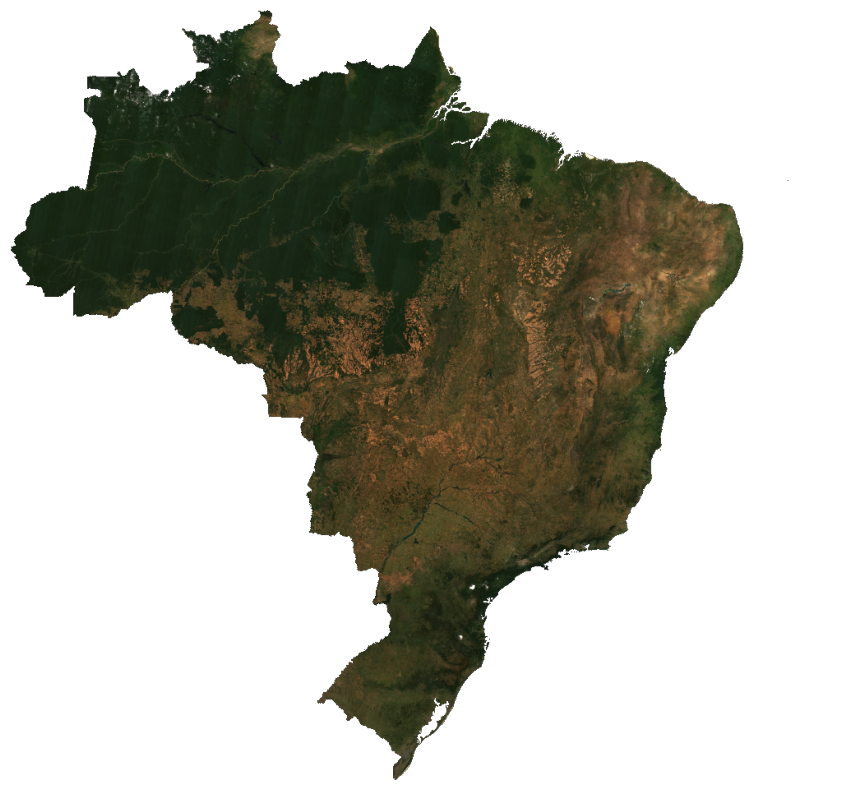

In [7]:
data = read_polygon(tileserver_xml(mosaic, level=5), brazil_aoi)
fig, ax = plt.subplots(figsize=(12, 10))
ax.imshow(rgb(data, display_max=2500))
ax.axis('off')
plt.show()

The demo client we used earlier also has a `tileserver_xml` method for each `Mosaic` instance.  Let's start using that. Additionally, we can request the tileserver to calculate several common remote sensing indices for us and stream floating point values directly in. This is done by using the `proc` query param to the tileserver alongside the `format=geotiff` query param to indicate that we watn to stream full bit depth tiles instead of an 8-bit visualization.  Supported `proc` arguments are detailed in https://developers.planet.com/docs/basemaps/tile-services/indices/. 

Let's leverage that and create a quick NDVI difference map between July 2021 and July 2024 of an alluvial gold mining region in Peru. Newly created mines (many of these are unpermitted and illegal) remove forest and will be visible as strongly decreased NDVI values displayed as brown in this visualization:

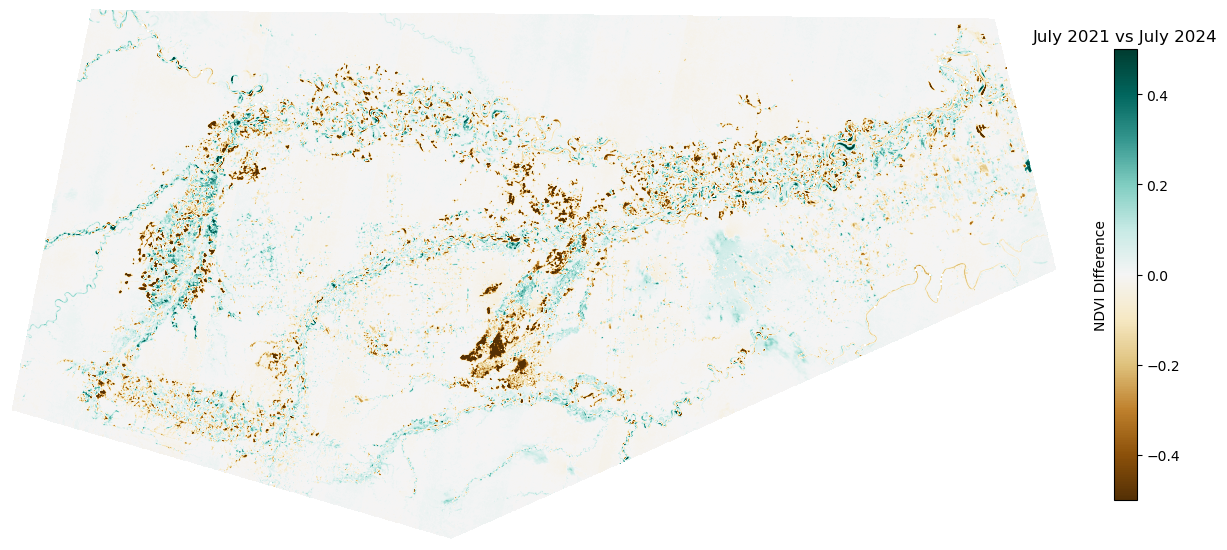

In [8]:
def read_ndvi(name, level, aoi, proc='ndvi'):
    mosaic = basemaps_client.Mosaic.from_name(name)
    vals, = read_polygon(mosaic.tileserver_xml(proc=proc, level=level), aoi)
    # Unfortunately, using the tileserver for this means that we don't handle nodata correctly.
    # 0 _is_ a valid NDVI value, and there's no alpha band or NaNs with proc=ndvi...
    return np.ma.masked_equal(vals, 0)

large_mining_aoi = {"type": "Polygon", "coordinates": [[[-70.6697, -12.4495], [-70.7885, -13.0305], [-70.1342, -13.2171], [-69.2351, -12.8274], [-69.3274, -12.4618], [-70.6697,-12.4495]]]}

ndvi_t1 = read_ndvi('planet_medres_normalized_analytic_2021-07_mosaic', 11, large_mining_aoi)
ndvi_t2 = read_ndvi('planet_medres_normalized_analytic_2024-07_mosaic', 11, large_mining_aoi)

ndvi_diff = ndvi_t2 - ndvi_t1

fig, ax = plt.subplots(figsize=(12, 10))
im = ax.imshow(ndvi_diff, vmin=-0.5, vmax=0.5, cmap="BrBG")
cbar = fig.colorbar(im, fraction=0.02, label='NDVI DIfference')
cbar.ax.set(title='July 2021 vs July 2024')
cbar.ax.yaxis.set(label_position='left')
ax.axis('off')
fig.tight_layout()
plt.show()

Example Use Case: Lake Area Monitoring
-----------------------------------------------------------

Let's explore an example use case in more detail now that we understand a bit more about how full bit depth streaming works. We'll focus on monitoring the area of a lake connected to the Amazon River system in the state Amazonas, Brazil.

Lake Tefé has great importance to a remote community located about ~500 km from Manaus, the state capital. The lake has reached its lowest point in Ocotber 2023 due to a severe drought. Lake Tefé is part of a large river system, and can therefore vary dramatically in size. We'll perform our analysis on the following AOI, which covers the area of its typical largest extent each year:

In [9]:
tefe_aoi = {"type": "Polygon", 
            "coordinates": [[[-64.8025, -3.2465], [-64.7196, -3.2873], [-64.6910, -3.3164], 
                             [-64.6779, -3.3481], [-64.6716, -3.4025], [-64.8310, -3.9132], 
                             [-65.1708, -3.8211], [-65.0408, -3.3146], [-64.8025, -3.2465]]]}

We'll use the Normalized Difference Water Index (NDWI) to distinguish water from land.  However, because PlanetScope data does image in Short Wavelength Infra Red (SWIR) wavelengths, we cannot use a traditional NDWI calculation and must instead use the variant based on Near Infra Red (NIR) + Green bands.  The NIR-based metric is less reliable, and we cannot reasonably assume that a constant threshold value will distinguish water from land. However, in this case, it is reasonable to assume that the histogram of values will be bimodal, and that the lower-valued mode usually represents water (be careful about that assumption when dealing with urban areas or bare earth alongside water).  Segmenting an image based on a bimodal histogram is a case that Otsu Thresholding is especially well-suited to.  Otsu Thresholding calculates a threshold value based on each input image (or mosaic, in this case) and finds the threshold that best separates the image into two classes. To avoid a relatively "heavy" dependency on the `skimage` or `opencv` libraries, let's create a quick Otsu Thresholding implementation based only on Numpy.

In [10]:
# In most cases, you'd want to use scikit-image or openCV for this.

def otsu_threshold(data, nbins=100):
    """Numpy-only implementation of Otsu Thresholding."""
    bins = np.linspace(np.nanmin(data), np.nanmax(data), nbins + 2)[1:-1]
    intraclass_var = lambda x: sum([cls.mean() * data.var(where=cls) for cls in [data >= x, data < x]])
    return data < min(bins, key=intraclass_var)

Now, let's take a look at what applying Otsu Thresholding to NDWI looks like for this region to make sure we're getting a reasonable result. We will have some false positives due to clouds, exposed bare ground, and cleared/developed areas in some cases, but those only contribute a small percentage of error for this relatively large AOI.

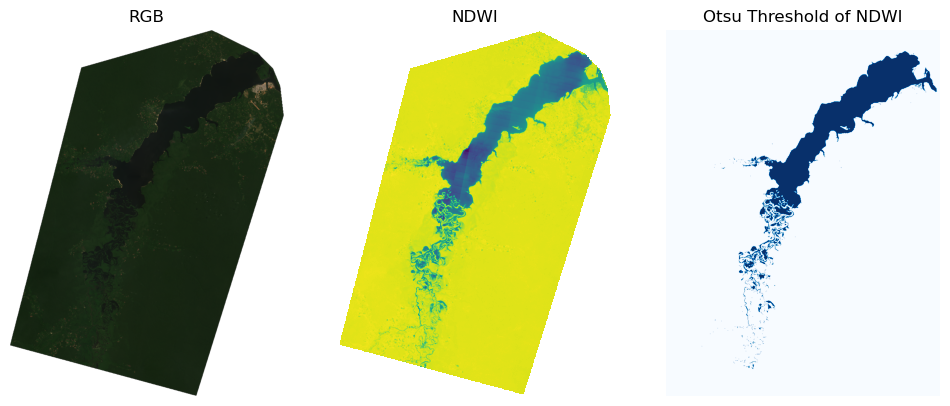

In [11]:
# We'll re-use this plotting method a bit later...
def display_segmentation(row, mosaic_name, aoi, level):
    mosaic = basemaps_client.Mosaic.from_name(mosaic_name)
    bgrn = read_polygon(mosaic.tileserver_xml(level=level), aoi)
    green, nir, alpha = bgrn[[1, 3, 4]]

    ndwi = (nir.astype(float) - green) / (nir + green)
    ndwi[alpha == 0] = np.nan

    water = otsu_threshold(ndwi)
    
    row[0].imshow(rgb(bgrn))
    row[0].set(title='RGB')
    row[1].imshow(ndwi, cmap='viridis')
    row[1].set(title='NDWI')
    row[2].imshow(water, cmap='Blues')
    row[2].set(title='Otsu Threshold of NDWI')
    
    return water
    

name = 'planet_medres_normalized_analytic_2023-08_mosaic'
level = 11

fig, axes = plt.subplots(ncols=3, figsize=(12, 10))
water = display_segmentation(axes, name, tefe_aoi, level)
for ax in axes.flat:
    ax.axis('off')
plt.show()

Now that we have thresholded water pixels into a boolean mask, let's turn that into area. We're currently doing this calculation in the native projection of the data, which has a systematic area distortion with latitude that we'll need to correct for. Given that this is a relatively small area, we can use a constant correction factor:

In [12]:
mosaic = basemaps_client.Mosaic.from_name(name)
with rio.open(mosaic.tileserver_xml(level=level)) as src:
    cellsize = src.res[0]

lat_center = np.mean([y for (x, y) in tefe_aoi['coordinates'][0]])
pixel_area = (cellsize * np.cos(np.radians(lat_center)))**2

area_sq_km = lambda mask: mask.sum() * pixel_area / 1e6

print('Area of Lake Tefé in August 2023')
print(f'{area_sq_km(water):0.1f} sq km')

Area of Lake Tefé in August 2023
296.8 sq km


Now let's analyze this through time to put the 2023 drought in historical perspective:

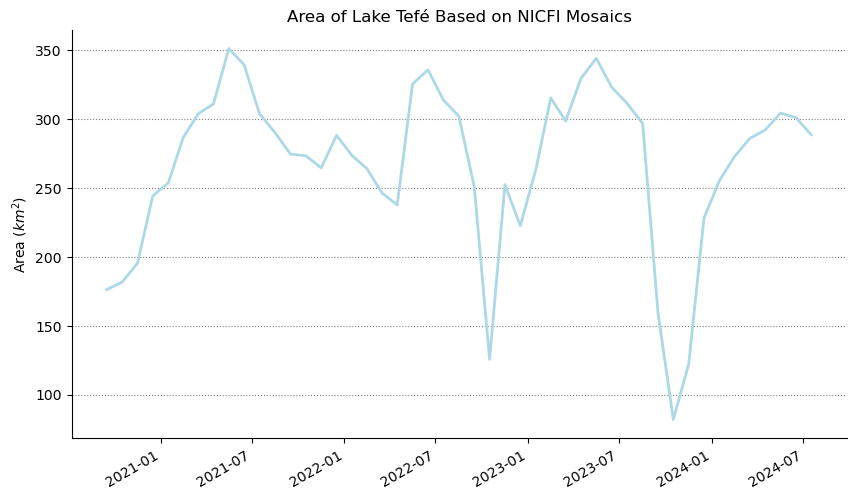

In [13]:
series_name = 'PS Tropical Normalized Analytic Monthly Monitoring'
series = basemaps_client.MosaicSeries.from_name(series_name)
level = 11

def water_area(mosaic):
    b, g, r, n, a = read_polygon(mosaic.tileserver_xml(level=level), tefe_aoi)
    ndwi = (n.astype(float) - g) / (n + g)
    ndwi[a == 0] = np.nan
    water = otsu_threshold(ndwi)
    return area_sq_km(water)

mosaics = list(series.mosaics(start_date='2020-09-01', end_date='2024-08-01'))
time = [x.start_date + (x.end_date - x.start_date) / 2 for x in mosaics]

# Using multiple threads to speed up data transfer, not processing
with ThreadPoolExecutor(max_workers=16) as executor:
    area = list(executor.map(water_area, mosaics))

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(time, area, color='lightblue', lw=2)
ax.grid(axis='y', ls=':', color='gray')
ax.set(ylabel=r'Area ($km^2$)', title='Area of Lake Tefé Based on NICFI Mosaics')
for side in ['top', 'right']:
    ax.spines[side].set(visible=False)
fig.autofmt_xdate()
plt.show()


Let's take a closer look at what's going on in October of 2023 and compare it to the peak levels a few months before:

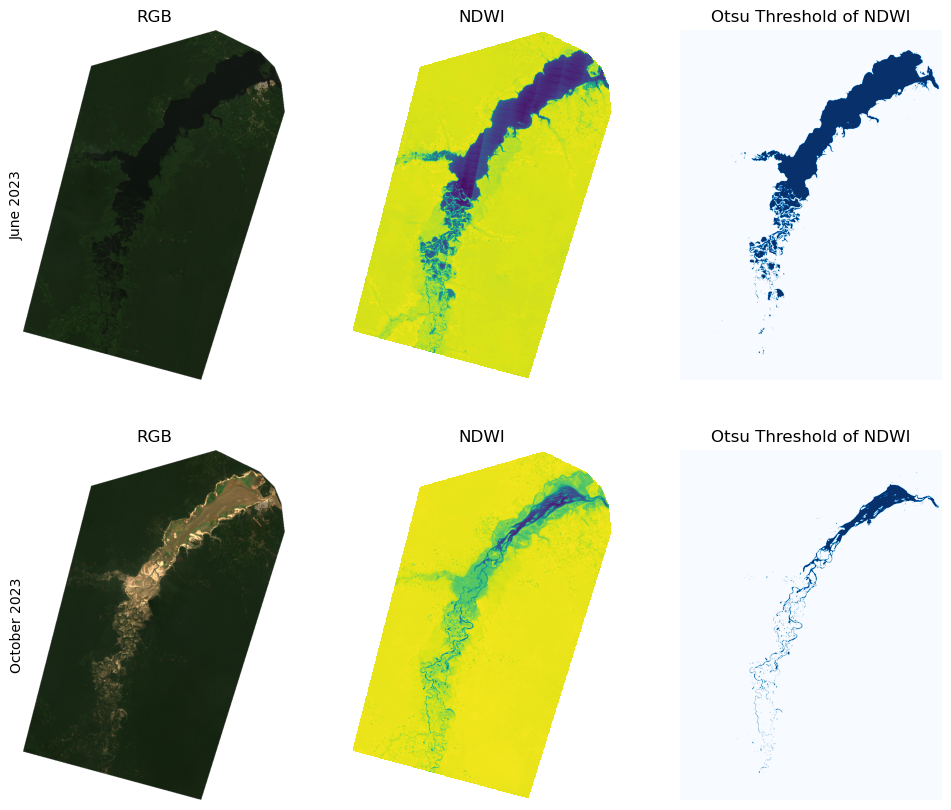

In [14]:
names = [
    'planet_medres_normalized_analytic_2023-06_mosaic',
    'planet_medres_normalized_analytic_2023-10_mosaic',
]
labels = ['June 2023', 'October 2023']

fig, axes = plt.subplots(nrows=len(names), ncols=3, figsize=(12, 10))

for row, name, label in zip(axes, names, labels):
    row[0].annotate(label, xy=(-0.05, 0.5), xycoords='axes fraction', va='center', rotation=90)
    display_segmentation(row, name, tefe_aoi, level)

for ax in axes.flat:
    ax.axis('off')
    
plt.show()

Summary
--------------

This guide aims to show how basemap data enables analysis without downloading or activating data at multiple scales and over broad areas. Full bit depth streaming enables you to treat basemap data as though each indivdual mosaic was a single local file. This allows analysis of any area using standard desktop GIS tools and standard raster data libraries without needing to download data beforehand. The techniques covered here can be applied to a variety of different use cases and hopefully provide the building blocks for work that you might want to do.